In [1]:
# Install required libraries
!pip install pandas numpy scikit-learn torch matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

In [4]:
# Load the data
data = pd.read_csv('IBM2017.csv')

In [5]:
# Ensure the 'Date' column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [6]:
# Extract temporal features
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day

In [7]:
# Prepare features and target variable
X = data[['Year', 'Month', 'Day', 'Volume']]
y = data['Close']  # Target: closing price

In [8]:
# Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [9]:
# Create sequences for Transformer model
def create_sequences(features, target, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
# Define sequence length
seq_length = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

In [12]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [13]:

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, num_layers, hidden_dim, seq_length):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, src):
        # src shape: [sequence_length, batch_size, input_dim]
        output = self.transformer_encoder(src)
        output = self.fc(output[-1, :, :])
        return output

In [14]:
# Initialize the model
input_dim = X_train.shape[2]  # Number of features
output_dim = 1
num_heads = 2
num_layers = 2
hidden_dim = 64

In [15]:
model = TransformerModel(input_dim, output_dim, num_heads, num_layers, hidden_dim, seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    src = X_train_tensor.permute(1, 0, 2)  # [seq_length, batch_size, input_dim]
    tgt = y_train_tensor.unsqueeze(1)  # [batch_size, output_dim]
    
    outputs = model(src)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 1.0098
Epoch [20/50], Loss: 0.9497
Epoch [30/50], Loss: 0.9175
Epoch [40/50], Loss: 0.8651
Epoch [50/50], Loss: 0.8192


In [17]:
# Prediction
model.eval()
with torch.no_grad():
    src_test = X_test_tensor.permute(1, 0, 2)
    y_pred = model(src_test).squeeze().numpy()

In [18]:
# Evaluate performance
y_test_inv = scaler_y.inverse_transform(y_test_tensor.numpy().reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.14875972270965576


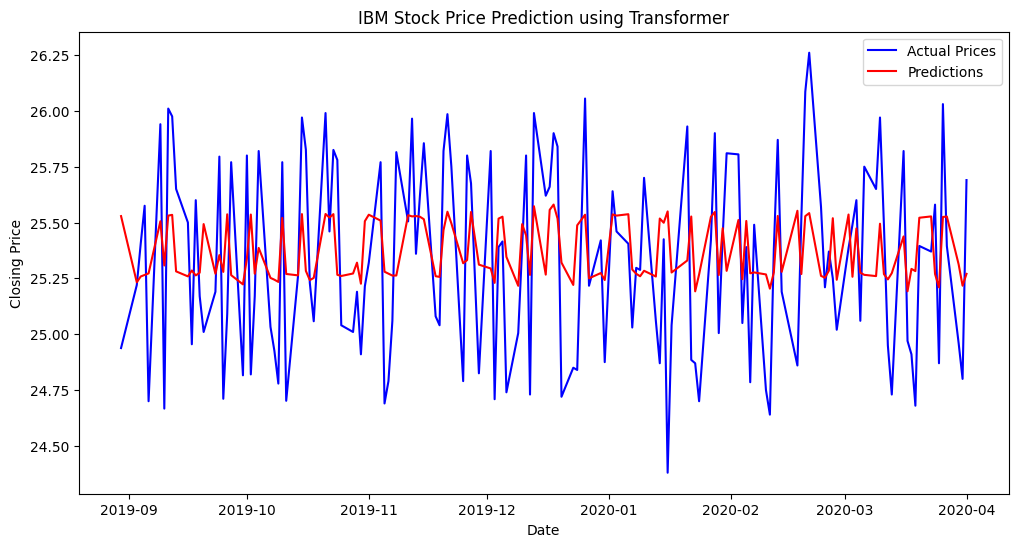

In [19]:
# Plot for visualization of results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label='Actual Prices', color='blue')
plt.plot(data.index[-len(y_pred_inv):], y_pred_inv, label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('IBM Stock Price Prediction using Transformer')
plt.legend()
plt.show()

Explanation of the Script:

    Install Required Libraries:
        Ensure you have pandas, numpy, scikit-learn, torch, and matplotlib installed.

    Load the Data:
        Load the IBM stock data from IBM2017.csv.

    Convert Dates and Extract Features:
        Convert the Date column to datetime format and set it as the index.
        Extract features and normalize them.

    Create Sequences:
        Generate sequences for the Transformer model.

    Convert to PyTorch Tensors:
        Convert features and target variables to PyTorch tensors.

    Define the Transformer Model:
        Create a Transformer model with specified dimensions and layers.

    Initialize and Train the Model:
        Define the model, loss function, and optimizer.
        Train the model.

    Make Predictions and Evaluate:
        Predict closing prices and calculate the Mean Squared Error (MSE).

    Plot Results:
        Plot the actual vs. predicted closing prices.

Notes:

    Adjust model hyperparameters (num_heads, num_layers, hidden_dim) as needed for your dataset.
    Ensure the file path 'IBM2017.csv' is correct and that the CSV file contains the necessary columns.
    The sequence length (seq_length) can be adjusted based on how much historical data you want to use for predictions.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d6ccbe74-5722-4f84-8e54-7da9a834c88a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>